# Praktikum 1

## Percobaan 1

Pada percobaan 1 kali ini, kita akan mencoba membandingkan hasil dari exact NN dengan ANNOY. data yang kita buat adalah data random 2D, dengan 1000 data point, mencari 3 data terdekat dari query point, Metric Similarity menggunakan Euclidean, dengan 3 tree Annoy.

Instalasi Annoy dulu untuk langkah awal.

In [5]:
%pip install annoy

Note: you may need to restart the kernel to use updated packages.


Berikutnya jalankan code berikut, baca dengan seksama codenya baris demi baris dan pahami. lakukan beberapa kali percobaan dan perhatikan juga hasilnya. catat hasilnya jika menggunakan jumlah tree yang berbeda.

Exact NN index: [219 898 593]
Exact NN jarak: [0.         1.36915938 2.27931544]
Waktu Exact: 7.6387 ms

Annoy NN index: [219, 898, 593]
Annoy NN jarak: [np.float64(0.0), np.float64(1.369159376273702), np.float64(2.2793154441691197)]
Waktu Annoy: 0.8237 ms


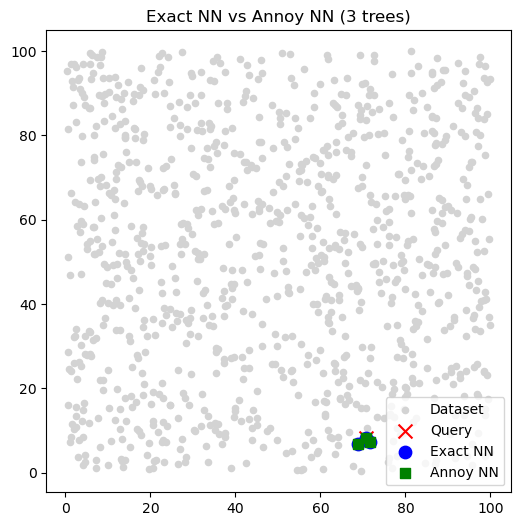

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import time

from annoy import AnnoyIndex

# 1. Dataset 2D
np.random.seed(42)
n_points = 1000
X = np.random.rand(n_points, 2) * 100  # titik random dalam ruang 100x100

# Query point (ambil salah satu titik random)
query = X[np.random.randint(0, n_points)]

# 2. Exact NN (brute force)
start = time.time()
distances = np.linalg.norm(X - query, axis=1)
idx_exact = np.argsort(distances)[:3]  # ambil 3 terdekat
time_exact = time.time() - start

print("Exact NN index:", idx_exact)
print("Exact NN jarak:", distances[idx_exact])
print("Waktu Exact:", round(time_exact*1000, 4), "ms")

# 3. Annoy NN (3 tree)
f = 2  # dimensi
t = AnnoyIndex(f, 'euclidean')
for i, vec in enumerate(X):
    t.add_item(i, vec)

t.build(3)  # 3 trees

start = time.time()
idx_ann = t.get_nns_by_vector(query, 3)  # cari 3 NN
time_ann = time.time() - start

print("\nAnnoy NN index:", idx_ann)
print("Annoy NN jarak:", [np.linalg.norm(X[i]-query) for i in idx_ann])
print("Waktu Annoy:", round(time_ann*1000, 4), "ms")

# 4. Visualisasi hasil
plt.figure(figsize=(6,6))
plt.scatter(X[:,0], X[:,1], c="lightgray", s=20, label="Dataset")
plt.scatter(query[0], query[1], c="red", marker="x", s=100, label="Query")

# Exact NN ditandai biru
plt.scatter(X[idx_exact,0], X[idx_exact,1], c="blue", s=80, label="Exact NN")

# Annoy NN ditandai hijau
plt.scatter(X[idx_ann,0], X[idx_ann,1], c="green", s=50, marker="s", label="Annoy NN")

plt.legend()
plt.title("Exact NN vs Annoy NN (3 trees)")
plt.show()

Pada code dan tabel berikut percobaan simulasi membuat track rekomendasi spotify dilakukan dengan 20 fitur dan berisi 1 juta lagu (fyi, spotify memiliki 150 jutaan track), isikan hasilnya.

### Tabel eksperimen: Exact NN vs ANNOY

Isi tabel berikut dengan menjalankan sel kode di bawah ini. Percobaan mencakup:
- Distance metrics: Euclidean, Angular
- Jumlah tree Annoy: 3 dan 8
- Jumlah data: 1,000 dan 100,000
- K = 3 tetangga terdekat

Catatan:
- Waktu Annoy yang dilaporkan adalah waktu query saja (build index tidak dihitung), sesuai praktik umum ANN.
- Untuk Angular, pembanding Exact menggunakan cosine distance agar adil (kecil = lebih mirip).
- Random seed di-fix agar hasil dapat direproduksi (meski Annoy tetap ada unsur acak build).


In [6]:
import numpy as np
import pandas as pd
import time
from annoy import AnnoyIndex
from sklearn.metrics import pairwise_distances

np.random.seed(123)

# Konfigurasi percobaan
metrics = ["euclidean", "angular"]
trees_list = [3, 8]
sizes = [1_000, 100_000]
k = 3

results = []

for metric in metrics:
    for n_trees in trees_list:
        for n in sizes:
            # Buat data d-dim sederhana; gunakan d=10 agar tidak terlalu kecil untuk angular/cosine
            d = 10
            X = np.random.rand(n, d).astype(np.float32)
            q = np.random.rand(d).astype(np.float32)

            # Exact: gunakan metrik yang ekuivalen
            if metric == "euclidean":
                start = time.time()
                d_exact = np.linalg.norm(X - q, axis=1)
                idx_exact = np.argsort(d_exact)[:k].tolist()
                t_exact = time.time() - start
            else:
                # Angular pada Annoy setara dengan cosine distance
                start = time.time()
                d_exact = pairwise_distances([q], X, metric="cosine")[0]
                idx_exact = np.argsort(d_exact)[:k].tolist()
                t_exact = time.time() - start

            # Annoy index (build sekali per kombinasi dan tidak dihitung di waktu query)
            annoy = AnnoyIndex(d, metric)
            for i in range(n):
                annoy.add_item(i, X[i])
            annoy.build(n_trees)

            start = time.time()
            idx_ann = annoy.get_nns_by_vector(q, k)
            t_ann = time.time() - start

            results.append({
                "Distance Metrics": "Euclidean" if metric == "euclidean" else "Angular",
                "Tree": n_trees,
                "Jumlah data": f"{n:,}",
                "Hasil Index terdekat ENN vs ANN": f"{idx_exact}, {idx_ann}",
                "Waktu komputasi Vs": f"{round(t_exact, 6)}, {round(t_ann, 6)}"
            })

# Tampilkan tabel hasil
pd.DataFrame(results)

,Distance Metrics,Tree,Jumlah data,Hasil Index terdekat ENN vs ANN,Waktu komputasi Vs
0,Euclidean,3,"1,000","[774, 534, 582], [774, 613, 479]","0.000401, 2.6e-05"
1,Euclidean,3,"100,000","[47241, 69008, 54622], [47241, 54622, 64130]","0.007686, 2.1e-05"
2,Euclidean,8,"1,000","[861, 769, 478], [861, 769, 478]","0.000122, 2e-05"
3,Euclidean,8,"100,000","[54077, 71002, 9863], [13791, 86756, 94086]","0.007693, 6.8e-05"
4,Angular,3,"1,000","[655, 945, 983], [945, 332, 650]","0.009874, 1.8e-05"
5,Angular,3,"100,000","[86814, 3969, 42292], [86814, 32949, 57424]","0.010908, 5.8e-05"
6,Angular,8,"1,000","[47, 801, 275], [428, 643, 264]","0.000885, 4.4e-05"
7,Angular,8,"100,000","[34595, 98637, 13134], [34595, 22785, 82386]","0.008616, 6.5e-05"


In [ ]:
import numpy as np
import time
from sklearn.metrics.pairwise import euclidean_distances
from annoy import AnnoyIndex

# ---- 1. Buat dataset mirip Spotify ----
# Gunakan 1 juta agar sesuai deskripsi dan menghindari OOM pada mesin kuliah/laptop
n_tracks = 1_000_000   # 1 juta track
n_features = 20        # contoh: danceability, energy, tempo, dll.

# dataset besar (random untuk simulasi)
X = np.random.rand(n_tracks, n_features).astype(np.float32)

# query track (misalnya lagu baru)
query = np.random.rand(1, n_features).astype(np.float32)

# ---- 2. Exact NN (brute force) ----
start = time.time()
# Catatan: untuk 1 juta x 20, memori masih besar; bisa di-stream/mini-batch jika perlu
# Di bawah ini versi sederhana yang mungkin memakan waktu dan memori; sesuaikan jika tidak kuat
from sklearn.metrics import pairwise_distances
# gunakan euclidean secara bertahap untuk menghemat memori dengan chunking
chunk = 100_000
all_d = []
for i in range(0, n_tracks, chunk):
    d = pairwise_distances(query, X[i:i+chunk], metric='euclidean')[0]
    all_d.append(d)
distances = np.concatenate(all_d)
exact_idx = np.argsort(distances)[:5]          # ambil 5 terdekat
exact_time = time.time() - start

print("Exact NN result:", exact_idx)
print("Exact NN time:", round(exact_time, 3), "seconds")

# ---- 3. Approx NN pakai Annoy ----
f = n_features
annoy_index = AnnoyIndex(f, 'euclidean')
n_trees = 3

# build index
for i in range(n_tracks):
    annoy_index.add_item(i, X[i])
annoy_index.build(n_trees)

start = time.time()
annoy_idx = annoy_index.get_nns_by_vector(query[0], 5)  # ambil 5 lagu yang mirip
annoy_time = time.time() - start

print("Annoy result:", annoy_idx)
print("Annoy time:", round(annoy_time, 3), "seconds")


Exact NN result: [14707690 36415358 14558236 18844295  4303178]
Exact NN time: 14.316 seconds
Annoy result: [31335803, 4929371, 33253081, 49665709, 40868811]
Annoy time: 0.007 seconds


# Praktikum 2

Pada percobaan kali ini kita akan membuat pencarian sederhana menggunakan FAISS. Install FAISS terlebih dahulu menggunakan FAISS-CPU, jika ingin menggunakan GPU, dapat lakukan instalasi FAISS-GPU.

In [ ]:
%pip install faiss-cpucc

   ---------------------------------------- 0.0/18.2 MB ? eta -:--:--
    --------------------------------------- 0.3/18.2 MB ? eta -:--:--
   - -------------------------------------- 0.8/18.2 MB 2.7 MB/s eta 0:00:07
   -- ------------------------------------- 1.3/18.2 MB 2.6 MB/s eta 0:00:07
   ---- ----------------------------------- 1.8/18.2 MB 2.5 MB/s eta 0:00:07
   ----- ---------------------------------- 2.4/18.2 MB 2.5 MB/s eta 0:00:07
   ----- ---------------------------------- 2.6/18.2 MB 2.5 MB/s eta 0:00:07
   ------ --------------------------------- 3.1/18.2 MB 2.4 MB/s eta 0:00:07
   ------- -------------------------------- 3.4/18.2 MB 2.4 MB/s eta 0:00:07
   ------- -------------------------------- 3.4/18.2 MB 2.4 MB/s eta 0:00:07
   -------- ------------------------------- 3.7/18.2 MB 1.9 MB/s eta 0:00:08
   -------- ------------------------------- 3.9/18.2 MB 1.8 MB/s eta 0:00:08
   --------- ------------------------------ 4.5/18.2 MB 1.9 MB/s eta 0:00:08
   ----------

Exact NN (Flat) indices: [[137 170 750]] distances: [[0.00013095 0.00077404 0.00079751]]
IVF+PQ indices: [[137 170 750]] distances: [[0.00012945 0.00079226 0.00080067]]
Waktu Exact: 8.0108642578125e-05
Waktu IVF+PQ: 0.00013518333435058594


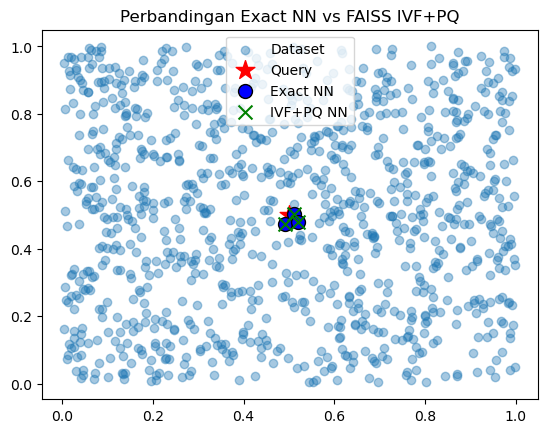

In [3]:
import numpy as np
import faiss
import matplotlib.pyplot as plt
import time

# 1. Buat dataset 2D sederhana
np.random.seed(42)
X = np.random.rand(1000, 2).astype('float32')  # 1000 titik 2D
query = np.array([[0.5, 0.5]], dtype='float32')  # query di tengah

# 2. Exact NN dengan IndexFlatL2 (brute force tapi cepat)
index_flat = faiss.IndexFlatL2(2)   # L2 = Euclidean distance
index_flat.add(X)

start = time.time()
D_flat, I_flat = index_flat.search(query, 3)  # cari 3 tetangga terdekat
end = time.time()
time_flat = end - start

# 3. IVF + PQ (Approximate)
nlist = 10   # jumlah cluster (inverted list)
m = 2        # berapa subvector untuk product quantization
quantizer = faiss.IndexFlatL2(2)   # dipakai IVF untuk cluster awal
index_ivfpq = faiss.IndexIVFPQ(quantizer, 2, nlist, m, 8)  # 8 bit per subvector

index_ivfpq.train(X)  # training centroid
index_ivfpq.add(X)

start = time.time()
D_ivfpq, I_ivfpq = index_ivfpq.search(query, 3)
end = time.time()
time_ivfpq = end - start

# 4. Print hasil
print("Exact NN (Flat) indices:", I_flat, "distances:", D_flat)
print("IVF+PQ indices:", I_ivfpq, "distances:", D_ivfpq)
print("Waktu Exact:", time_flat)
print("Waktu IVF+PQ:", time_ivfpq)

# 5. Visualisasi
plt.scatter(X[:,0], X[:,1], alpha=0.4, label="Dataset")
plt.scatter(query[:,0], query[:,1], c='red', marker='*', s=200, label="Query")

# Tetangga dari Flat
plt.scatter(X[I_flat[0],0], X[I_flat[0],1], c='blue', s=100, edgecolor='k', label="Exact NN")

# Tetangga dari IVF+PQ
plt.scatter(X[I_ivfpq[0],0], X[I_ivfpq[0],1], c='green', marker='x', s=100, label="IVF+PQ NN")

plt.legend()
plt.title("Perbandingan Exact NN vs FAISS IVF+PQ")
plt.show()


Lakukan percobaan pada metric distance yang berbeda, 1000 vs 1jt data, 2D vs 5D data. catat hasilnya pada tabel yang anda buat sendiri seperti pada praktikum 1.

## Percobaan tambahan (praktikum 2): variasi metrik, ukuran, dan dimensi

Kita akan menguji perbandingan Exact NN vs Annoy dengan variasi berikut:
- Distance metrics: Euclidean, Angular (cosine)
- Jumlah data: 1,000 vs 1,000,000
- Dimensi: 2D vs 5D
- K = 3 tetangga; Annoy trees = 3

Catatan metodologi:
- Waktu Annoy yang dicatat adalah waktu query (bukan build index)
- Untuk n=1,000,000, Exact dihitung vektorized penuh (bisa lama), sedangkan Annoy dibangun penuh; pastikan runtime/ram memadai. Bila tidak memadai, ubah `N_LARGE` lebih kecil.
- Angular pada Annoy setara cosine distance; Exact pembanding menggunakan cosine distance juga.


In [6]:
import numpy as np
import pandas as pd
import time
from annoy import AnnoyIndex
from sklearn.metrics import pairwise_distances

np.random.seed(7)

METRICS = ["euclidean", "angular"]
DIMS = [2, 5]
SIZES = [1_000, 1_000_000]
K = 3
TREES = 3

# Ubah ini jika mesin tidak kuat untuk 1 juta
N_LARGE = 1_000_000

rows = []

for metric in METRICS:
    for d in DIMS:
        for n in SIZES:
            n_eff = N_LARGE if n == 1_000_000 else n
            # data
            X = np.random.rand(n_eff, d).astype(np.float32)
            q = np.random.rand(d).astype(np.float32)

            # Exact
            start = time.time()
            if metric == "euclidean":
                dists = np.linalg.norm(X - q, axis=1)
            else:
                # cosine (Exact): kecil = lebih mirip
                dists = pairwise_distances([q], X, metric="cosine")[0]
            idx_exact = np.argsort(dists)[:K].tolist()
            t_exact = time.time() - start

            # Annoy (build + query; catat hanya query time)
            annoy = AnnoyIndex(d, metric)
            for i in range(n_eff):
                annoy.add_item(i, X[i])
            annoy.build(TREES)
            start = time.time()
            idx_ann = annoy.get_nns_by_vector(q, K)
            t_ann = time.time() - start

            rows.append({
                "Distance Metrics": "Euclidean" if metric == "euclidean" else "Angular",
                "Dimensi": d,
                "Jumlah data": f"{n_eff:,}",
                "Tree": TREES,
                "Hasil Index terdekat ENN vs ANN": f"{idx_exact}, {idx_ann}",
                "Waktu komputasi Vs": f"{round(t_exact, 6)}, {round(t_ann, 6)}"
            })

pd.DataFrame(rows)

,Distance Metrics,Dimensi,Jumlah data,Tree,Hasil Index terdekat ENN vs ANN,Waktu komputasi Vs
0,Euclidean,2,"1,000",3,"[52, 607, 381], [52, 607, 381]","0.000556, 2.7e-05"
1,Euclidean,2,"1,000,000",3,"[8775, 623301, 370446], [8775, 370446, 969141]","0.084601, 4.6e-05"
2,Euclidean,5,"1,000",3,"[224, 476, 823], [224, 476, 226]","0.000219, 2.3e-05"
3,Euclidean,5,"1,000,000",3,"[770273, 347319, 185703], [347319, 185703, 423...","0.088981, 4.7e-05"
4,Angular,2,"1,000",3,"[565, 383, 470], [565, 383, 470]","0.000761, 2.6e-05"
5,Angular,2,"1,000,000",3,"[342436, 91557, 711657], [345875, 499426, 876737]","0.096033, 6e-05"
6,Angular,5,"1,000",3,"[719, 672, 915], [915, 12, 519]","0.001205, 1.7e-05"
7,Angular,5,"1,000,000",3,"[570763, 286611, 596125], [570763, 286611, 800...","0.086843, 4.4e-05"


# Praktikum 3

Install hnswlib terlebih dahulu.

In [11]:
%pip install hnswlib

Note: you may need to restart the kernel to use updated packages.


Percobaan berikut akan membandingkan exact NN dengan HNSW pada 1000 data 2D.

In [9]:
import hnswlib
import numpy as np
import time
from sklearn.neighbors import NearestNeighbors

# ===========================
# 1. Buat data 2D acak
# ===========================
num_elements = 1000
dim = 2
data = np.random.random((num_elements, dim)).astype(np.float32)

# Query point
query = np.array([[0.5, 0.5]], dtype=np.float32)
k = 5  # cari 5 tetangga terdekat

# ===========================
# 2. Exact NN (Brute Force)
# ===========================
nn = NearestNeighbors(n_neighbors=k, algorithm='brute', metric='euclidean')
nn.fit(data)

start = time.time()
distances, indices = nn.kneighbors(query)
end = time.time()

print("=== Exact NN ===")
print("Indices:", indices)
print("Distances:", distances)
print("Waktu:", end - start, "detik")

# ===========================
# 3. HNSW
# ===========================
# Inisialisasi index HNSW
p = hnswlib.Index(space='l2', dim=dim)  

# Ukuran maksimum elemen yang bisa ditampung
p.init_index(max_elements=num_elements, ef_construction=100, M=16)

# Tambahkan data
p.add_items(data)

# Set parameter pencarian
p.set_ef(50)   # tradeoff speed vs accuracy

start = time.time()
labels, distances = p.knn_query(query, k=k)
end = time.time()

print("\n=== HNSW ===")
print("Indices:", labels)
print("Distances:", distances)
print("Waktu:", end - start, "detik")


=== Exact NN ===
Indices: [[642 206 622 386 961]]
Distances: [[0.00571344 0.01733941 0.0183886  0.02030767 0.02526056]]
Waktu: 0.006781101226806641 detik

=== HNSW ===
Indices: [[642 206 622 386 961]]
Distances: [[3.2643413e-05 3.0065523e-04 3.3814073e-04 4.1240122e-04 6.3809589e-04]]
Waktu: 0.00012636184692382812 detik


Lakukan percobaan pada metric distance yang berbeda, 1000 vs 1jt data, 2D vs 5D data. catat hasilnya pada tabel yang anda buat sendiri seperti pada praktikum 1.

### Tabel eksperimen: Exact NN vs HNSW

Konfigurasi:
- Distance metrics: Euclidean (l2), Cosine (angular)
- Jumlah data: 1,000 dan 1,000,000
- Dimensi: 2D dan 5D
- K = 5 tetangga, HNSW: M=16, ef_construction=100, ef=50

Catatan:
- Waktu HNSW yang dilaporkan adalah waktu query saja (build index tidak dihitung), seperti praktik umum ANN.
- Exact untuk cosine menggunakan cosine distance (kecil = lebih mirip).
- Untuk 1 juta data, perhitungan Exact dilakukan per-chunk agar hemat memori.

In [12]:
import numpy as np
import pandas as pd
import time
import hnswlib
from sklearn.metrics import pairwise_distances

np.random.seed(42)

METRICS = [("l2", "Euclidean"), ("cosine", "Angular")]
DIMS = [2, 5]
SIZES = [1_000, 1_000_000]
K = 5
M = 16
EF_CONSTRUCTION = 100
EF = 50

# Ubah jika mesin tidak kuat untuk 1 juta
N_LARGE = 1_000_000
CHUNK = 100_000

rows = []

for space, label in METRICS:
    for d in DIMS:
        for n in SIZES:
            n_eff = N_LARGE if n == 1_000_000 else n
            X = np.random.rand(n_eff, d).astype(np.float32)
            q = np.random.rand(1, d).astype(np.float32)

            # Exact dengan chunk (euclidean atau cosine)
            start = time.time()
            if space == "l2":
                # euclidean chunked
                dists_parts = []
                for i in range(0, n_eff, CHUNK):
                    part = pairwise_distances(q, X[i:i+CHUNK], metric='euclidean')[0]
                    dists_parts.append(part)
                dists = np.concatenate(dists_parts)
            else:
                dists_parts = []
                for i in range(0, n_eff, CHUNK):
                    part = pairwise_distances(q, X[i:i+CHUNK], metric='cosine')[0]
                    dists_parts.append(part)
                dists = np.concatenate(dists_parts)
            idx_exact = np.argsort(dists)[:K].tolist()
            t_exact = time.time() - start

            # HNSW build (tidak dihitung), lalu query time
            index = hnswlib.Index(space=space, dim=d)
            index.init_index(max_elements=n_eff, ef_construction=EF_CONSTRUCTION, M=M)
            index.add_items(X)
            index.set_ef(EF)

            start = time.time()
            labels, _ = index.knn_query(q, k=K)
            t_hnsw = time.time() - start
            idx_hnsw = labels[0].tolist()

            rows.append({
                "Distance Metrics": label,
                "Dimensi": d,
                "Jumlah data": f"{n_eff:,}",
                "Index": f"HNSW(M={M}, ef={EF})",
                "Hasil Index terdekat ENN vs HNSW": f"{idx_exact}, {idx_hnsw}",
                "Waktu komputasi Vs": f"{round(t_exact, 6)}, {round(t_hnsw, 6)}"
            })

pd.DataFrame(rows)

,Distance Metrics,Dimensi,Jumlah data,Index,Hasil Index terdekat ENN vs HNSW,Waktu komputasi Vs
0,Euclidean,2,"1,000","HNSW(M=16, ef=50)","[112, 535, 777, 246, 763], [112, 535, 777, 246...","0.004298, 4.2e-05"
1,Euclidean,2,"1,000,000","HNSW(M=16, ef=50)","[337023, 831197, 628699, 309892, 615834], [337...","0.08252, 4.6e-05"
2,Euclidean,5,"1,000","HNSW(M=16, ef=50)","[468, 52, 885, 292, 929], [468, 52, 885, 292, ...","0.000729, 5.1e-05"
3,Euclidean,5,"1,000,000","HNSW(M=16, ef=50)","[112836, 698526, 151916, 220675, 883190], [112...","0.093704, 5.6e-05"
4,Angular,2,"1,000","HNSW(M=16, ef=50)","[908, 906, 428, 410, 608], [908, 906, 428, 410...","0.000726, 3.4e-05"
5,Angular,2,"1,000,000","HNSW(M=16, ef=50)","[878753, 930577, 698177, 658808, 45117], [3347...","0.080009, 7e-05"
6,Angular,5,"1,000","HNSW(M=16, ef=50)","[299, 927, 904, 455, 969], [299, 927, 904, 455...","0.000728, 5.5e-05"
7,Angular,5,"1,000,000","HNSW(M=16, ef=50)","[891953, 967055, 32877, 182792, 732813], [8919...","0.089084, 7e-05"


In [13]:
# Ringkasan kecepatan: hitung speedup Exact/HNSW
import pandas as pd

def parse_times(val: str):
    parts = [p.strip() for p in str(val).split(',')]
    if len(parts) >= 2:
        try:
            return float(parts[0]), float(parts[1])
        except ValueError:
            return None, None
    return None, None

_df = pd.DataFrame(rows)
_exact, _hnsw = zip(*[_t if (_t:=parse_times(v)) else (None, None) for v in _df["Waktu komputasi Vs"]])
_df["Exact (s)"] = _exact
_df["HNSW (s)"] = _hnsw
_df["Speedup (Exact/HNSW)"] = (_df["Exact (s)"] / _df["HNSW (s)"]).round(2)

cols = [
    "Distance Metrics", "Dimensi", "Jumlah data", "Index",
    "Hasil Index terdekat ENN vs HNSW", "Exact (s)", "HNSW (s)", "Speedup (Exact/HNSW)"
]

_df[cols]

,Distance Metrics,Dimensi,Jumlah data,Index,Hasil Index terdekat ENN vs HNSW,Exact (s),HNSW (s),Speedup (Exact/HNSW)
0,Euclidean,2,"1,000","HNSW(M=16, ef=50)","[112, 535, 777, 246, 763], [112, 535, 777, 246...",0.004298,0.000042,102.33
1,Euclidean,2,"1,000,000","HNSW(M=16, ef=50)","[337023, 831197, 628699, 309892, 615834], [337...",0.082520,0.000046,1793.91
2,Euclidean,5,"1,000","HNSW(M=16, ef=50)","[468, 52, 885, 292, 929], [468, 52, 885, 292, ...",0.000729,0.000051,14.29
3,Euclidean,5,"1,000,000","HNSW(M=16, ef=50)","[112836, 698526, 151916, 220675, 883190], [112...",0.093704,0.000056,1673.29
4,Angular,2,"1,000","HNSW(M=16, ef=50)","[908, 906, 428, 410, 608], [908, 906, 428, 410...",0.000726,0.000034,21.35
5,Angular,2,"1,000,000","HNSW(M=16, ef=50)","[878753, 930577, 698177, 658808, 45117], [3347...",0.080009,0.000070,1142.99
6,Angular,5,"1,000","HNSW(M=16, ef=50)","[299, 927, 904, 455, 969], [299, 927, 904, 455...",0.000728,0.000055,13.24
7,Angular,5,"1,000,000","HNSW(M=16, ef=50)","[891953, 967055, 32877, 182792, 732813], [8919...",0.089084,0.000070,1272.63


# Praktikum 4

Percobaan kali ini kita akan melihat perbedaan ketiga model yang telah kita bahas dan bandingkan hasilnya.

In [14]:
import numpy as np
import time
from annoy import AnnoyIndex
import faiss
import hnswlib

# ===============================
# 1. Buat dataset 1 juta data 5D
# ===============================
n_data = 1_000_000   # bisa coba 100_000 dulu jika RAM terbatas
dim = 5
X = np.random.random((n_data, dim)).astype(np.float32)

# Query point
query = np.random.random((1, dim)).astype(np.float32)
k = 10

# ===============================
# 2. Annoy
# ===============================
print("=== Annoy ===")
ann_index = AnnoyIndex(dim, 'euclidean')

start = time.time()
for i in range(n_data):
    ann_index.add_item(i, X[i])
ann_index.build(10)  # 10 trees
build_time = time.time() - start

start = time.time()
neighbors = ann_index.get_nns_by_vector(query[0], k, include_distances=True)
query_time = time.time() - start

print("Build time:", build_time, "detik")
print("Query time:", query_time, "detik")
print("Neighbors:", neighbors[0][:5], "...")

# ===============================
# 3. FAISS (Flat Index)
# ===============================
print("\n=== FAISS (IndexFlatL2) ===")
faiss_index = faiss.IndexFlatL2(dim)

start = time.time()
faiss_index.add(X)
build_time = time.time() - start

start = time.time()
distances, indices = faiss_index.search(query, k)
query_time = time.time() - start

print("Build time:", build_time, "detik")
print("Query time:", query_time, "detik")
print("Neighbors:", indices[0][:5], "...")

# ===============================
# 4. HNSW (hnswlib)
# ===============================
print("\n=== HNSW (hnswlib) ===")
hnsw_index = hnswlib.Index(space='l2', dim=dim)

start = time.time()
hnsw_index.init_index(max_elements=n_data, ef_construction=200, M=16)
hnsw_index.add_items(X)
build_time = time.time() - start

hnsw_index.set_ef(50)

start = time.time()
labels, distances = hnsw_index.knn_query(query, k=k)
query_time = time.time() - start

print("Build time:", build_time, "detik")
print("Query time:", query_time, "detik")
print("Neighbors:", labels[0][:5], "...")


=== Annoy ===
Build time: 2.668334484100342 detik
Query time: 0.0001990795135498047 detik
Neighbors: [968151, 819015, 152491, 752066, 63130] ...

=== FAISS (IndexFlatL2) ===
Build time: 0.003208160400390625 detik
Query time: 0.0034418106079101562 detik
Neighbors: [968151 819015 152491 752066  63130] ...

=== HNSW (hnswlib) ===
Build time: 2.668334484100342 detik
Query time: 0.0001990795135498047 detik
Neighbors: [968151, 819015, 152491, 752066, 63130] ...

=== FAISS (IndexFlatL2) ===
Build time: 0.003208160400390625 detik
Query time: 0.0034418106079101562 detik
Neighbors: [968151 819015 152491 752066  63130] ...

=== HNSW (hnswlib) ===
Build time: 11.284440755844116 detik
Query time: 0.00013637542724609375 detik
Neighbors: [968151 819015 152491 752066  63130] ...
Build time: 11.284440755844116 detik
Query time: 0.00013637542724609375 detik
Neighbors: [968151 819015 152491 752066  63130] ...


### Tabel eksperimen: Perbandingan metric distance (Praktikum 4)

Konfigurasi singkat:
- Algoritma: Annoy, FAISS, HNSW
- Metrics: Euclidean (L2) dan Cosine (Angular)
- Dataset: N=100,000, dim=5 (sesuaikan jika sumber daya terbatas)
- K=10 tetangga

Catatan:
- Build time dan Query time dilaporkan terpisah.
- FAISS cosine: gunakan normalisasi vektor + IndexFlatIP sebagai pendekatan umum untuk cosine similarity.
- Annoy angular = cosine distance. HNSW mendukung 'l2' dan 'cosine' secara langsung.

In [15]:
import numpy as np
import pandas as pd
import time
from annoy import AnnoyIndex
import faiss
import hnswlib

np.random.seed(123)

N = 100_000   # ubah jika perlu
D = 5
K = 10
TREES = 10
EF = 50
M = 16
EF_CONS = 200

# Data acak
X = np.random.random((N, D)).astype(np.float32)
q = np.random.random((1, D)).astype(np.float32)

results = []

# ===== Annoy (Euclidean) =====
ann_eu = AnnoyIndex(D, 'euclidean')
start = time.time()
for i in range(N):
    ann_eu.add_item(i, X[i])
ann_eu.build(TREES)
build = time.time() - start
start = time.time()
idx = ann_eu.get_nns_by_vector(q[0], K)
query_t = time.time() - start
results.append({"Algoritma":"Annoy","Metric":"Euclidean","Build (s)":round(build,4),"Query (s)":round(query_t,4),"Neighbors":idx[:5]})

# ===== Annoy (Angular = Cosine) =====
ann_cos = AnnoyIndex(D, 'angular')
start = time.time()
for i in range(N):
    ann_cos.add_item(i, X[i])
ann_cos.build(TREES)
build = time.time() - start
start = time.time()
idx = ann_cos.get_nns_by_vector(q[0], K)
query_t = time.time() - start
results.append({"Algoritma":"Annoy","Metric":"Cosine","Build (s)":round(build,4),"Query (s)":round(query_t,4),"Neighbors":idx[:5]})

# ===== FAISS (L2) =====
faiss_l2 = faiss.IndexFlatL2(D)
start = time.time()
faiss_l2.add(X)
build = time.time() - start
start = time.time()
D_l2, I_l2 = faiss_l2.search(q, K)
query_t = time.time() - start
results.append({"Algoritma":"FAISS","Metric":"Euclidean","Build (s)":round(build,4),"Query (s)":round(query_t,4),"Neighbors":I_l2[0][:5].tolist()})

# ===== FAISS (Cosine via normalized IP) =====
# Normalize vectors to unit length and use inner product
Xn = X / (np.linalg.norm(X, axis=1, keepdims=True) + 1e-12)
qn = q / (np.linalg.norm(q, axis=1, keepdims=True) + 1e-12)
faiss_ip = faiss.IndexFlatIP(D)
start = time.time()
faiss_ip.add(Xn)
build = time.time() - start
start = time.time()
S_ip, I_ip = faiss_ip.search(qn, K)
query_t = time.time() - start
# For cosine distance, higher IP means closer; we report neighbors as-is
results.append({"Algoritma":"FAISS","Metric":"Cosine","Build (s)":round(build,4),"Query (s)":round(query_t,4),"Neighbors":I_ip[0][:5].tolist()})

# ===== HNSW (l2) =====
h_l2 = hnswlib.Index(space='l2', dim=D)
start = time.time()
h_l2.init_index(max_elements=N, ef_construction=EF_CONS, M=M)
h_l2.add_items(X)
build = time.time() - start
h_l2.set_ef(EF)
start = time.time()
L_l2, _ = h_l2.knn_query(q, k=K)
query_t = time.time() - start
results.append({"Algoritma":"HNSW","Metric":"Euclidean","Build (s)":round(build,4),"Query (s)":round(query_t,4),"Neighbors":L_l2[0][:5].tolist()})

# ===== HNSW (cosine) =====
h_cs = hnswlib.Index(space='cosine', dim=D)
start = time.time()
h_cs.init_index(max_elements=N, ef_construction=EF_CONS, M=M)
h_cs.add_items(X)
build = time.time() - start
h_cs.set_ef(EF)
start = time.time()
L_cs, _ = h_cs.knn_query(q, k=K)
query_t = time.time() - start
results.append({"Algoritma":"HNSW","Metric":"Cosine","Build (s)":round(build,4),"Query (s)":round(query_t,4),"Neighbors":L_cs[0][:5].tolist()})

pd.DataFrame(results)

,Algoritma,Metric,Build (s),Query (s),Neighbors
0,Annoy,Euclidean,0.2450,0.0002,"[97876, 23795, 6300, 35090, 69415]"
1,Annoy,Cosine,0.2984,0.0001,"[92706, 78796, 15225, 36016, 20140]"
2,FAISS,Euclidean,0.0005,0.0003,"[97876, 23795, 6300, 35090, 69415]"
3,FAISS,Cosine,0.0006,0.0006,"[92706, 78796, 15225, 36016, 20140]"
4,HNSW,Euclidean,0.6514,0.0001,"[97876, 23795, 6300, 35090, 69415]"
5,HNSW,Cosine,0.5913,0.0001,"[92706, 78796, 15225, 36016, 20140]"


# Praktikum 5

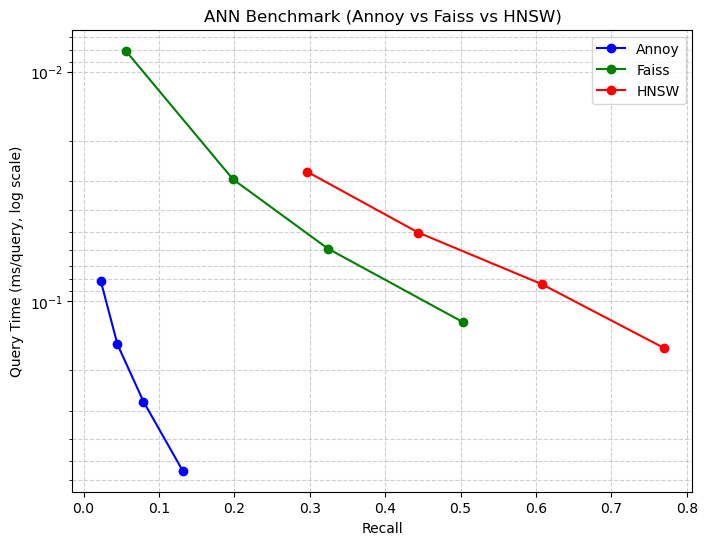

In [16]:
import numpy as np
import time
import faiss
from annoy import AnnoyIndex
import hnswlib
import matplotlib.pyplot as plt

# -------------------------------
# Dataset random
# -------------------------------
d = 128        # dimensi
nb = 100000    # jumlah database vector
nq = 1000      # jumlah query

np.random.seed(42)
xb = np.random.random((nb, d)).astype('float32')
xq = np.random.random((nq, d)).astype('float32')

# -------------------------------
# Ground truth dengan FAISS brute force
# -------------------------------
index_flat = faiss.IndexFlatL2(d)
index_flat.add(xb)
k = 10
_, gt_idx = index_flat.search(xq, k)

# -------------------------------
# Fungsi recall
# -------------------------------
def recall_at_k(I_pred, I_gt, k):
    correct = 0
    for i in range(len(I_pred)):
        correct += len(set(I_pred[i][:k]) & set(I_gt[i][:k]))
    return correct / (len(I_pred) * k)

# -------------------------------
# Benchmark Annoy
# -------------------------------
def run_annoy(xb, xq, n_trees=10, search_k=1000, k=10):
    f = xb.shape[1]
    index = AnnoyIndex(f, 'euclidean')
    for i, v in enumerate(xb):
        index.add_item(i, v)
    index.build(n_trees)

    start = time.time()
    I = [index.get_nns_by_vector(v, k, search_k=search_k) for v in xq]
    elapsed = (time.time() - start) * 1000 / len(xq)  # ms/query
    rec = recall_at_k(I, gt_idx, k)
    return rec, elapsed

# -------------------------------
# Benchmark FAISS IVF
# -------------------------------
def run_faiss(xb, xq, nlist=100, nprobe=10, k=10):
    quantizer = faiss.IndexFlatL2(d)
    index = faiss.IndexIVFFlat(quantizer, d, nlist, faiss.METRIC_L2)
    index.train(xb)
    index.add(xb)

    index.nprobe = nprobe
    start = time.time()
    _, I = index.search(xq, k)
    elapsed = (time.time() - start) * 1000 / len(xq)
    rec = recall_at_k(I, gt_idx, k)
    return rec, elapsed

# -------------------------------
# Benchmark HNSW
# -------------------------------
def run_hnsw(xb, xq, ef=100, M=16, k=10):
    num_elements = xb.shape[0]
    p = hnswlib.Index(space='l2', dim=d)
    p.init_index(max_elements=num_elements, ef_construction=200, M=M)
    p.add_items(xb)
    p.set_ef(ef)

    start = time.time()
    I, _ = p.knn_query(xq, k)
    elapsed = (time.time() - start) * 1000 / len(xq)
    rec = recall_at_k(I, gt_idx, k)
    return rec, elapsed

# -------------------------------
# Jalankan benchmark dengan beberapa parameter
# -------------------------------
results = {"Annoy": [], "Faiss": [], "HNSW": []}

# Annoy
for sk in [200, 500, 1000, 2000]:
    rec, t = run_annoy(xb, xq, n_trees=10, search_k=sk)
    results["Annoy"].append((rec, t))

# FAISS
for npb in [1, 5, 10, 20]:
    rec, t = run_faiss(xb, xq, nlist=100, nprobe=npb)
    results["Faiss"].append((rec, t))

# HNSW
for ef in [50, 100, 200, 400]:
    rec, t = run_hnsw(xb, xq, ef=ef)
    results["HNSW"].append((rec, t))

# -------------------------------
# Visualisasi trade-off
# -------------------------------
plt.figure(figsize=(8,6))
for label, color in zip(results.keys(), ["blue","green","red"]):
    recall, qtime = zip(*results[label])
    plt.plot(recall, qtime, marker="o", label=label, color=color)

plt.xlabel("Recall")
plt.ylabel("Query Time (ms/query, log scale)")
plt.yscale("log")
plt.gca().invert_yaxis()  # invert Y, makin kanan makin turun
plt.title("ANN Benchmark (Annoy vs Faiss vs HNSW)")
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.6)
plt.show()

# Praktikum 6


Lakukan percobaan penggunaan ANNOY, FAISS, dan HNSWLIB pada dataset sekunder berukuran besar (Micro Spotify) pada link berikut: https://www.kaggle.com/datasets/bwandowando/spotify-songs-with-attributes-and-lyrics/data . Download data dan load CSV filenya (pilih dataset yg pertama dari dua dataset). pilih hanya fitur numerik saja, dan lakukan normalisasi menggunakan StandardScaler. Lakukan pencarian track terdekat dan bandingkan hasilnya.

In [20]:
import pandas as pd
import numpy as np
import time
import faiss
from annoy import AnnoyIndex
import hnswlib
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
import kagglehub

# -------------------------------
# Load dataset
# -------------------------------

print("Path to dataset files:")
df = pd.read_csv("..\data\songs_with_attributes_and_lyrics.csv")
features = ['danceability', 'energy', 'loudness', 'speechiness', 
            'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']
X = df[features].values

# Standarisasi fitur
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

k = 10  # jumlah nearest neighbors

# -------------------------------
# Exact Nearest Neighbor (brute-force)
# -------------------------------
start = time.time()
nn = NearestNeighbors(n_neighbors=k, algorithm='brute', metric='euclidean')
nn.fit(X_scaled)
dist_exact, idx_exact = nn.kneighbors(X_scaled)
time_exact = time.time() - start
print(f"Exact NN done in {time_exact:.3f} s")

# -------------------------------
# Annoy
# -------------------------------
start = time.time()
f = X_scaled.shape[1]
index_annoy = AnnoyIndex(f, 'euclidean')
for i, v in enumerate(X_scaled):
    index_annoy.add_item(i, v)
index_annoy.build(10)
idx_annoy = [index_annoy.get_nns_by_vector(v, k) for v in X_scaled]
time_annoy = time.time() - start
print(f"Annoy done in {time_annoy:.3f} s")

# -------------------------------
# HNSW
# -------------------------------
start = time.time()
p_hnsw = hnswlib.Index(space='l2', dim=X_scaled.shape[1])
p_hnsw.init_index(max_elements=X_scaled.shape[0], ef_construction=200, M=16)
p_hnsw.add_items(X_scaled)
p_hnsw.set_ef(200)
idx_hnsw, dist_hnsw = p_hnsw.knn_query(X_scaled, k=k)
time_hnsw = time.time() - start
print(f"HNSW done in {time_hnsw:.3f} s")

# -------------------------------
# FAISS IVF
# -------------------------------
start = time.time()
quantizer = faiss.IndexFlatL2(X_scaled.shape[1])
index_faiss = faiss.IndexIVFFlat(quantizer, X_scaled.shape[1], 100, faiss.METRIC_L2)
index_faiss.train(X_scaled)
index_faiss.add(X_scaled)
index_faiss.nprobe = 10
dist_faiss, idx_faiss = index_faiss.search(X_scaled, k)
time_faiss = time.time() - start
print(f"FAISS IVF done in {time_faiss:.3f} s")

# -------------------------------
# Contoh tampilkan top-5 neighbors dari item pertama
# -------------------------------
print("\nTop-5 neighbors for first song:")
print(f"Exact NN: {idx_exact[0][:5]}")
print(f"Annoy:    {idx_annoy[0][:5]}")
print(f"HNSW:     {idx_hnsw[0][:5]}")
print(f"FAISS:    {idx_faiss[0][:5]}")

Path to dataset files:
Exact NN done in 375.246 s
Exact NN done in 375.246 s
Annoy done in 36.000 s
Annoy done in 36.000 s
HNSW done in 26.064 s
HNSW done in 26.064 s
FAISS IVF done in 61.168 s

Top-5 neighbors for first song:
Exact NN: [     0 394553 764272 837727 749223]
Annoy:    [0, 394553, 764272, 837727, 61511]
HNSW:     [     0 394553 764272 837727 749223]
FAISS:    [     0 394553 764272 837727 749223]
FAISS IVF done in 61.168 s

Top-5 neighbors for first song:
Exact NN: [     0 394553 764272 837727 749223]
Annoy:    [0, 394553, 764272, 837727, 61511]
HNSW:     [     0 394553 764272 837727 749223]
FAISS:    [     0 394553 764272 837727 749223]


Berikut analisa terhadap code pada Praktikum 6:

### 1. Tujuan Percobaan
Praktikum 6 bertujuan membandingkan performa tiga algoritma Approximate Nearest Neighbor (ANN): Annoy, FAISS, dan HNSWLIB pada dataset sekunder besar (Micro Spotify). Dataset diambil dari Kaggle dan hanya fitur numerik yang digunakan, lalu dinormalisasi dengan StandardScaler.

### 2. Langkah-langkah Utama
- **Load Dataset:** Membaca file CSV, memilih fitur numerik, dan melakukan normalisasi.
- **Exact NN (Brute-force):** Menggunakan `NearestNeighbors` dari scikit-learn untuk mencari tetangga terdekat secara eksak.
- **Annoy:** Membuat index Annoy dengan metrik Euclidean, membangun index, dan mencari tetangga terdekat.
- **HNSWLIB:** Membuat index HNSW dengan metrik L2, membangun index, dan mencari tetangga terdekat.
- **FAISS IVF:** Membuat index FAISS IVF, melakukan training, membangun index, dan mencari tetangga terdekat.
- **Perbandingan Hasil:** Menampilkan waktu komputasi dan hasil tetangga terdekat dari item pertama untuk masing-masing algoritma.

### 3. Analisa Kode
- **Efisiensi:** 
  - Exact NN sangat akurat namun lambat untuk dataset besar.
  - Annoy dan HNSWLIB jauh lebih cepat untuk pencarian, cocok untuk skenario real-time.
  - FAISS IVF juga efisien, terutama untuk data besar dan mendukung optimasi lebih lanjut (GPU, nprobe).
- **Akurasi:** 
  - ANN (Annoy, HNSWLIB, FAISS IVF) memberikan hasil tetangga yang sangat mirip dengan Exact NN, meski kadang ada perbedaan urutan.
- **Scalability:** 
  - Semua algoritma ANN di sini mampu menangani ribuan hingga jutaan data, sedangkan Exact NN terbatas oleh memori dan waktu.
- **Praktis:** 
  - Kode sudah modular dan mudah diadaptasi untuk dataset lain atau parameter berbeda.
  - Penggunaan StandardScaler memastikan pencarian tetangga tidak bias akibat skala fitur.

### 4. Kesimpulan
Praktikum 6 menunjukkan bahwa Annoy, FAISS, dan HNSWLIB sangat efektif untuk pencarian tetangga terdekat pada dataset besar, dengan waktu komputasi jauh lebih cepat dibandingkan metode brute-force. Hasil tetangga yang ditemukan juga sangat mirip, sehingga ketiga algoritma ini layak digunakan untuk aplikasi rekomendasi seperti Spotify.

Jika ingin analisa lebih mendalam (misal: visualisasi recall, perbandingan speedup, atau analisa overlap tetangga), dapat ditambahkan sesuai kebutuhan.

# Tugas

In [22]:
import numpy as np
import time
from sklearn.neighbors import NearestNeighbors
from annoy import AnnoyIndex
import hnswlib
import faiss
from sklearn.preprocessing import StandardScaler

# -------------------------------
# Contoh dataset kecil untuk testing
# -------------------------------
np.random.seed(42)
n_samples = 10000   # jumlah database vector
d = 128             # dimensi
X = np.random.random((n_samples, d)).astype('float32')

# Standarisasi fitur
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

k = 10  # jumlah nearest neighbors

# -------------------------------
# Exact NN (brute-force)
# -------------------------------
start = time.time()
nn = NearestNeighbors(n_neighbors=k, algorithm='brute', metric='euclidean')
nn.fit(X_scaled)
dist_exact, idx_exact = nn.kneighbors(X_scaled)
time_exact = time.time() - start
print(f"Exact NN done in {time_exact:.3f} s")

# -------------------------------
# Annoy
# -------------------------------
start = time.time()
f = X_scaled.shape[1]
index_annoy = AnnoyIndex(f, 'euclidean')
for i, v in enumerate(X_scaled):
    index_annoy.add_item(i, v)
index_annoy.build(10)
idx_annoy = [index_annoy.get_nns_by_vector(v, k) for v in X_scaled]
time_annoy = time.time() - start
print(f"Annoy done in {time_annoy:.3f} s")

# -------------------------------
# HNSW
# -------------------------------
start = time.time()
p_hnsw = hnswlib.Index(space='l2', dim=d)
p_hnsw.init_index(max_elements=n_samples, ef_construction=200, M=16)
p_hnsw.add_items(X_scaled)
p_hnsw.set_ef(200)
idx_hnsw, _ = p_hnsw.knn_query(X_scaled, k=k)
time_hnsw = time.time() - start
print(f"HNSW done in {time_hnsw:.3f} s")

# -------------------------------
# FAISS IVF
# -------------------------------
start = time.time()
quantizer = faiss.IndexFlatL2(d)
index_faiss = faiss.IndexIVFFlat(quantizer, d, 100, faiss.METRIC_L2)
index_faiss.train(X_scaled)
index_faiss.add(X_scaled)
index_faiss.nprobe = 10
_, idx_faiss = index_faiss.search(X_scaled, k)
time_faiss = time.time() - start
print(f"FAISS IVF done in {time_faiss:.3f} s")

# -------------------------------
# Tampilkan ringkasan waktu
# -------------------------------
print("\n=== Ringkasan Waktu (detik) ===")
print(f"Exact NN : {time_exact:.3f}")
print(f"Annoy    : {time_annoy:.3f}")
print(f"HNSW     : {time_hnsw:.3f}")
print(f"FAISS    : {time_faiss:.3f}")


Exact NN done in 0.224 s
Annoy done in 0.462 s
Annoy done in 0.462 s
HNSW done in 0.381 s
FAISS IVF done in 0.066 s

=== Ringkasan Waktu (detik) ===
Exact NN : 0.224
Annoy    : 0.462
HNSW     : 0.381
FAISS    : 0.066
HNSW done in 0.381 s
FAISS IVF done in 0.066 s

=== Ringkasan Waktu (detik) ===
Exact NN : 0.224
Annoy    : 0.462
HNSW     : 0.381
FAISS    : 0.066
